In [13]:
import re
import csv
import torch as th
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
#import nltk
from collections import Counter 
import matplotlib.pyplot as plt
from math import log
import time
import pickle

# On génère les série temporelle

In [2]:
def generate_first_type_time_series(D):
    return np.array([[np.sin(np.divide(2*np.pi*i*t, 64)) for t in range(128)] for i in range(1,D+1)])

In [3]:
def generate_second_type_time_series(D):
    fst_type = generate_first_type_time_series(D)
    result = []
    frac = 1/(D-1)
    for i in range(1,D+1):
        loc = []
        for t in range(1,129):
            fst = fst_type[i-1,t-1]
            snd=frac*np.sum(np.delete(fst_type[:,t-1], i-1, axis=0))
            loc.append(fst+snd)
        result.append(loc)
    return np.array(result)

In [4]:
def generate_third_type_time_series(D):
    fst_type = generate_first_type_time_series(D)
    result = []
    frac = 1/(D-1)
    for i in range(1,D+1):
        loc = []
        for t in range(1,129):
            fst = fst_type[i-1,t-1]
            snd=frac*np.sum(np.delete(fst_type[:,t-1], i-1, axis=0))+ fst**2
            loc.append(fst+snd)
        result.append(loc)
    return np.array(result)

In [5]:
def generate_fourth_type_time_series(D):
    fst_type = generate_first_type_time_series(D)
    result = []
    frac = 1/(D-1)
    for i in range(1,D+1):
        loc = []            
        for t in range(1,129):
            if(i==D):
                loc.append(np.random.randn())
            else:
                fst = fst_type[i-1,t-1]
                snd=frac*np.sum(np.delete(fst_type[:,t-1], i-1, axis=0))
                loc.append(fst+snd)
        result.append(loc)
    return np.array(result)

In [24]:
def get_loader(D, MTS):
    data = []
    labels = []
    
    if MTS:
        series = generate_second_type_time_series(D)
    else : 
        series = generate_first_type_time_series(D)
    
    series = series.T
    for i in range(0,64):
        data.append(series[i:i+64, :])
        labels.append(series[i+64 , :])
    
    
    data = np.array(data)
    labels = np.array(labels) 
    train_data = TensorDataset(th.from_numpy(data).type(th.LongTensor), th.from_numpy(labels))
    train_loader = DataLoader(train_data, shuffle=False, batch_size=1)
    
    return train_loader

In [7]:
class GRU_forecaster(nn.Module):
    def __init__(self, nb_cells, hidden_size, input_size, rnn_dropout, window_size, conv_size):
        super(GRU_forecaster, self).__init__()
        
        self.nb_cells = nb_cells
        self.hidden_size = hidden_size
        self.input_size = input_size
        
        self.gru = nn.GRU(input_size, hidden_size, nb_cells, batch_first = True, dropout=rnn_dropout)

        
        
        
        ###Par rapport au papier, k=nbr de filtres et m=hidden size
        self.convList = nn.ModuleList([nn.Conv1d(1,1,window_size-1) for i in range(conv_size)])#32 fixed in the paper

        self.Wa = nn.Linear(hidden_size, conv_size)
        self.Wh = nn.Linear(hidden_size, hidden_size)
        self.Wv = nn.Linear(conv_size, hidden_size)
        self.Whp = nn.Linear(hidden_size, input_size)
        
        self.sigmoid = nn.Sigmoid()
            
    
    def forward(self, inputs, h0):
        inputs = inputs.view(1,-1,input_size).float()
        
        rnn_out, last_h = self.gru(inputs, h0)
        hidden = rnn_out.transpose(1,2)[:,:,:-1]
        
        hc = th.Tensor() #size m*k
        #l_out = self.getNbFeatures()
        
        for conv in self.convList:
            t = th.Tensor()
            for h in hidden[0]:
                h = h.view(1,1,-1)
                x = conv(h)
                t=th.cat([t,x],0)
            t = t.view(-1,1)
            hc=th.cat([hc,t],1)
        
        attention_weights = self.Wa(last_h).view(-1,1)
        attention_weights = (hc@attention_weights)
        attention_weights = self.sigmoid(attention_weights)
        
        vt = (attention_weights*hc).sum(dim=0) #ai * Hci
        
        hp = self.Wv(vt)+self.Wh(last_h)
        out = self.Whp(hp)
        return out, h
    
    def init_hidden(self, batch_size):
        weight = next(self.parameters()).data
        #hidden = th.Tensor(self.nb_cells, batch_size, self.hidden_size)
        hidden = weight.new(self.nb_cells, batch_size, self.hidden_size).zero_()
        return hidden
    

In [8]:
def train(model,lr,loader, max_epochs=60):

    predictions = []
    start = time.time()
    optim = th.optim.Adam(params=model.parameters(), lr=lr, weight_decay=1e-4)
    model.train()
    for i in range(max_epochs):
        n = 0 
        h = model.init_hidden(1)
        train_mean_loss=0
        for x, labels in loader:
            
            optim.zero_grad()
            h = h.data
            
            n+=1
            preds, _ = model(x, h)  
            
            preds=preds.view(1,-1)
            if (i== max_epochs-1):
                predictions.append(preds)
            labels=labels.view(1,-1).float()
            loss = loss_fn(preds, labels)
            h = h.detach()
            train_mean_loss+=loss.item()
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), 5)
            optim.step()
        
#             if(n%20==0):
#                 print("step : {}/{} ".format(n, 64*D))
#                 print("step loss : ", log(train_mean_loss/n,10))  
        
#         rnn_train_losses.append(train_mean_loss/len(train_data))
       
        print("EPOCH {}".format(i+1))
        print("Train Mean loss : ",log(train_mean_loss/n,10))
        print("----------------------------------------")
    end = time.time()
    return(end-start,log(train_mean_loss/n,10), predictions)

In [8]:
nb_cells=1
D= 6
learning_rate = 1e-3
hidden_size=10
input_size = D
gru=GRU_forecaster(nb_cells,hidden_size, input_size, 0.0,64,8)
loss_fn = nn.L1Loss()
loader = get_loader(D, False)

In [11]:
time_, final_acc, predictions = train(gru, learning_rate,loader)

EPOCH 1
Train Mean loss :  -0.20623541053618452
----------------------------------------
EPOCH 2
Train Mean loss :  -0.23990243926827942
----------------------------------------
EPOCH 3
Train Mean loss :  -0.2498133549010543
----------------------------------------
EPOCH 4
Train Mean loss :  -0.25689317505062653
----------------------------------------
EPOCH 5
Train Mean loss :  -0.26802576656180077
----------------------------------------
EPOCH 6
Train Mean loss :  -0.27204302348486853
----------------------------------------
EPOCH 7
Train Mean loss :  -0.291495897645445
----------------------------------------
EPOCH 8
Train Mean loss :  -0.3313098477561546
----------------------------------------
EPOCH 9
Train Mean loss :  -0.3593001224762906
----------------------------------------
EPOCH 10
Train Mean loss :  -0.3789417445822691
----------------------------------------
EPOCH 11
Train Mean loss :  -0.413844363396983
----------------------------------------
EPOCH 12
Train Mean loss : 

In [156]:
times = []
final_accs = []
for dim in [1,6,11,16,21]:
    nb_cells=1
    learning_rate = 1e-3
    hidden_size=2*dim
    D=dim
    input_size=dim
    gru=GRU_forecaster(nb_cells,hidden_size, input_size, 0.0,64,8)
    loss_fn = nn.L1Loss()

    loader = get_loader(D, False)
    time_, final_acc, _ = train(gru, learning_rate,loader)
    times.append(time_)
    final_accs.append(final_acc)

EPOCH 1
Train Mean loss :  -0.12824002352129027
----------------------------------------
EPOCH 2
Train Mean loss :  -0.15212811768716666
----------------------------------------
EPOCH 3
Train Mean loss :  -0.16288467269007098
----------------------------------------
EPOCH 4
Train Mean loss :  -0.16775449789500518
----------------------------------------
EPOCH 5
Train Mean loss :  -0.17051041013801932
----------------------------------------
EPOCH 6
Train Mean loss :  -0.17543239412976966
----------------------------------------
EPOCH 7
Train Mean loss :  -0.17924610471466967
----------------------------------------
EPOCH 8
Train Mean loss :  -0.17948777559881163
----------------------------------------
EPOCH 9
Train Mean loss :  -0.18169736497229688
----------------------------------------
EPOCH 10
Train Mean loss :  -0.1817782372633372
----------------------------------------
EPOCH 11
Train Mean loss :  -0.18347887635706747
----------------------------------------
EPOCH 12
Train Mean 

EPOCH 34
Train Mean loss :  -0.9591633530891592
----------------------------------------
EPOCH 35
Train Mean loss :  -0.9449576793097623
----------------------------------------
EPOCH 36
Train Mean loss :  -0.967837496294778
----------------------------------------
EPOCH 37
Train Mean loss :  -0.913861982819303
----------------------------------------
EPOCH 38
Train Mean loss :  -1.0069941057878538
----------------------------------------
EPOCH 39
Train Mean loss :  -1.0170716320775104
----------------------------------------
EPOCH 40
Train Mean loss :  -0.9890999865186997
----------------------------------------
EPOCH 41
Train Mean loss :  -1.047018366886567
----------------------------------------
EPOCH 42
Train Mean loss :  -1.01569930910056
----------------------------------------
EPOCH 43
Train Mean loss :  -0.954924863210469
----------------------------------------
EPOCH 44
Train Mean loss :  -1.0015779747278133
----------------------------------------
EPOCH 45
Train Mean loss : 

EPOCH 7
Train Mean loss :  -0.2763034424879292
----------------------------------------
EPOCH 8
Train Mean loss :  -0.2908174071388866
----------------------------------------
EPOCH 9
Train Mean loss :  -0.307628203878834
----------------------------------------
EPOCH 10
Train Mean loss :  -0.32492932695990745
----------------------------------------
EPOCH 11
Train Mean loss :  -0.33765954279001326
----------------------------------------
EPOCH 12
Train Mean loss :  -0.3434349403144591
----------------------------------------
EPOCH 13
Train Mean loss :  -0.3559932455288989
----------------------------------------
EPOCH 14
Train Mean loss :  -0.3690730448497705
----------------------------------------
EPOCH 15
Train Mean loss :  -0.380829475455075
----------------------------------------
EPOCH 16
Train Mean loss :  -0.3941613120660273
----------------------------------------
EPOCH 17
Train Mean loss :  -0.40623304886424
----------------------------------------
EPOCH 18
Train Mean loss :

EPOCH 39
Train Mean loss :  -0.5349677151470988
----------------------------------------
EPOCH 40
Train Mean loss :  -0.5348944212282766
----------------------------------------
EPOCH 41
Train Mean loss :  -0.5431782556494208
----------------------------------------
EPOCH 42
Train Mean loss :  -0.5487714116147866
----------------------------------------
EPOCH 43
Train Mean loss :  -0.5516908684625286
----------------------------------------
EPOCH 44
Train Mean loss :  -0.5503331391446115
----------------------------------------
EPOCH 45
Train Mean loss :  -0.5664165697983956
----------------------------------------
EPOCH 46
Train Mean loss :  -0.5734297347897453
----------------------------------------
EPOCH 47
Train Mean loss :  -0.5782493870592357
----------------------------------------
EPOCH 48
Train Mean loss :  -0.5757410068261997
----------------------------------------
EPOCH 49
Train Mean loss :  -0.5760063868893407
----------------------------------------
EPOCH 50
Train Mean l

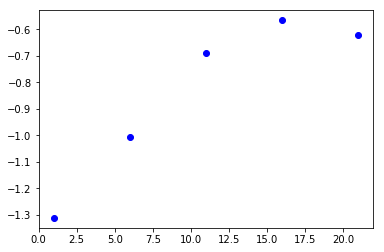

In [162]:
plt.plot([1,6,11,16,21], final_accs, 'bo' )

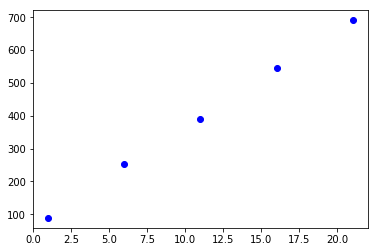

In [163]:
plt.plot([1,6,11,16,21], times , 'bo')

In [194]:
times = []
final_accs = []
for dim in [2,6,11,16,21]:
    nb_cells=1
    learning_rate = 1e-3
    hidden_size=2*dim
    D=dim
    input_size=dim
    gru=GRU_forecaster(nb_cells,hidden_size, input_size, 0.0,64,8)
    loss_fn = nn.L1Loss()

    loader = get_loader(D, True)
    time_, final_acc, _ = train(gru, learning_rate,loader)
    times.append(time_)
    final_accs.append(final_acc)

EPOCH 1
Train Mean loss :  -0.05119628430017212
----------------------------------------
EPOCH 2
Train Mean loss :  -0.13099379809941775
----------------------------------------
EPOCH 3
Train Mean loss :  -0.21679660041785337
----------------------------------------
EPOCH 4
Train Mean loss :  -0.4458262793766746
----------------------------------------
EPOCH 5
Train Mean loss :  -0.5585014342744385
----------------------------------------
EPOCH 6
Train Mean loss :  -0.551180613704098
----------------------------------------
EPOCH 7
Train Mean loss :  -0.6819119793533484
----------------------------------------
EPOCH 8
Train Mean loss :  -0.6866778616208504
----------------------------------------
EPOCH 9
Train Mean loss :  -0.6525184797439821
----------------------------------------
EPOCH 10
Train Mean loss :  -0.621751448927223
----------------------------------------
EPOCH 11
Train Mean loss :  -0.9708339258431483
----------------------------------------
EPOCH 12
Train Mean loss :  -

EPOCH 34
Train Mean loss :  -0.9242834979416972
----------------------------------------
EPOCH 35
Train Mean loss :  -1.043702748751845
----------------------------------------
EPOCH 36
Train Mean loss :  -1.0345861249875865
----------------------------------------
EPOCH 37
Train Mean loss :  -0.9536041421076492
----------------------------------------
EPOCH 38
Train Mean loss :  -0.8678272042127329
----------------------------------------
EPOCH 39
Train Mean loss :  -0.9915834865504116
----------------------------------------
EPOCH 40
Train Mean loss :  -1.057728785379833
----------------------------------------
EPOCH 41
Train Mean loss :  -1.0389990973006118
----------------------------------------
EPOCH 42
Train Mean loss :  -0.9266333646101219
----------------------------------------
EPOCH 43
Train Mean loss :  -0.8990770962440422
----------------------------------------
EPOCH 44
Train Mean loss :  -0.9717424879726052
----------------------------------------
EPOCH 45
Train Mean los

EPOCH 7
Train Mean loss :  -0.3348502776710083
----------------------------------------
EPOCH 8
Train Mean loss :  -0.35601624595723863
----------------------------------------
EPOCH 9
Train Mean loss :  -0.3760164964610459
----------------------------------------
EPOCH 10
Train Mean loss :  -0.3862767747774742
----------------------------------------
EPOCH 11
Train Mean loss :  -0.4009658390412781
----------------------------------------
EPOCH 12
Train Mean loss :  -0.41413829929748214
----------------------------------------
EPOCH 13
Train Mean loss :  -0.41883660671730344
----------------------------------------
EPOCH 14
Train Mean loss :  -0.42359301706391234
----------------------------------------
EPOCH 15
Train Mean loss :  -0.4346351777034495
----------------------------------------
EPOCH 16
Train Mean loss :  -0.4364551153464038
----------------------------------------
EPOCH 17
Train Mean loss :  -0.449158495680594
----------------------------------------
EPOCH 18
Train Mean l

EPOCH 39
Train Mean loss :  -0.4598417687204328
----------------------------------------
EPOCH 40
Train Mean loss :  -0.4670692186627078
----------------------------------------
EPOCH 41
Train Mean loss :  -0.46484963134176127
----------------------------------------
EPOCH 42
Train Mean loss :  -0.47586908349181745
----------------------------------------
EPOCH 43
Train Mean loss :  -0.4662447430441682
----------------------------------------
EPOCH 44
Train Mean loss :  -0.4778794635424936
----------------------------------------
EPOCH 45
Train Mean loss :  -0.47984810244306725
----------------------------------------
EPOCH 46
Train Mean loss :  -0.4794091588997603
----------------------------------------
EPOCH 47
Train Mean loss :  -0.4724718222804711
----------------------------------------
EPOCH 48
Train Mean loss :  -0.47753074045846516
----------------------------------------
EPOCH 49
Train Mean loss :  -0.4849356165800167
----------------------------------------
EPOCH 50
Train Me

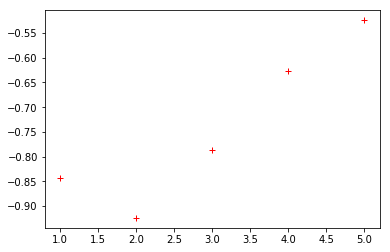

In [197]:
plt.plot([i for i in range(1,6)], final_accs, 'r+')

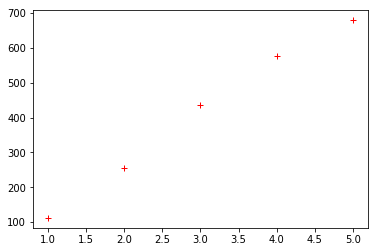

In [198]:
plt.plot([i for i in range(1,6)], times, 'r+')

# PLOT DES RESULTATS DE NOTRE MODELE ET COMPARAISON AVEC LE VRAI TRUC EN DIM 6


In [47]:
nb_cells=1
learning_rate = 1e-3
hidden_size=12
input_size=6
gru=GRU_forecaster(nb_cells,hidden_size, input_size, 0.0,64,8)
loss_fn = nn.L1Loss()
D= 6
loader = get_loader(D, False)
_ , _ , predictions  = train(gru, learning_rate,loader, 60)

EPOCH 1
Train Mean loss :  -0.159727907558105
----------------------------------------


KeyboardInterrupt: 

In [187]:
prediction_list = []
for i in range(D):
    l = []
    for j in range(64):
        l.append(predictions[j][0][i])
    prediction_list.append(l)

In [188]:
true_list = generate_first_type_time_series(6)

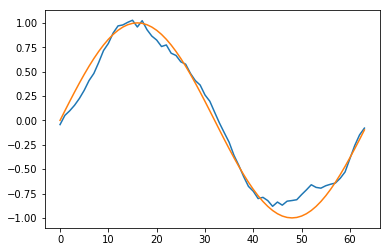

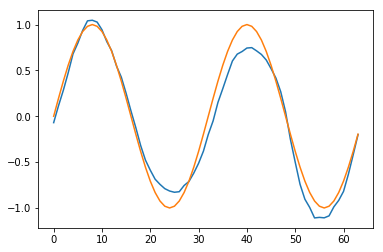

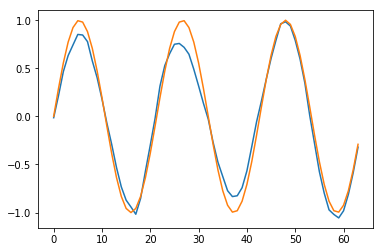

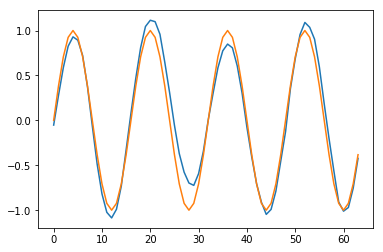

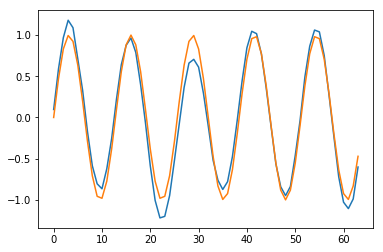

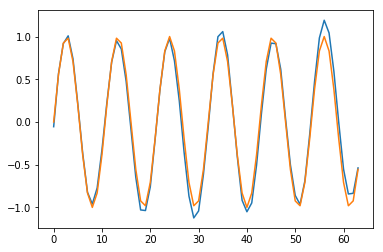

In [192]:
for i in range(D):
    plt.plot(prediction_list[i])
    plt.plot(true_list[i][64:])
    plt.show()

## SECOND TOY EXAMPLES PLOTS

In [199]:
nb_cells=1
learning_rate = 1e-3
hidden_size=12
input_size=6
gru=GRU_forecaster(nb_cells,hidden_size, input_size, 0.0,64,8)
loss_fn = nn.L1Loss()
D= 6
loader = get_loader(D, True)
_ , _ , predictions  = train(gru, learning_rate,loader, 60)

EPOCH 1
Train Mean loss :  -0.15726713274134904
----------------------------------------
EPOCH 2
Train Mean loss :  -0.16124897153322668
----------------------------------------
EPOCH 3
Train Mean loss :  -0.21125050853533092
----------------------------------------
EPOCH 4
Train Mean loss :  -0.2760366678240294
----------------------------------------
EPOCH 5
Train Mean loss :  -0.3984562807516678
----------------------------------------
EPOCH 6
Train Mean loss :  -0.5193876692378129
----------------------------------------
EPOCH 7
Train Mean loss :  -0.5392701372239891
----------------------------------------
EPOCH 8
Train Mean loss :  -0.6235701795753246
----------------------------------------
EPOCH 9
Train Mean loss :  -0.655193976020206
----------------------------------------
EPOCH 10
Train Mean loss :  -0.6261300372233601
----------------------------------------
EPOCH 11
Train Mean loss :  -0.6800273953329246
----------------------------------------
EPOCH 12
Train Mean loss :  

In [200]:
prediction_list = []
for i in range(D):
    l = []
    for j in range(64):
        l.append(predictions[j][0][i])
    prediction_list.append(l)

In [201]:
true_list = generate_second_type_time_series(6)

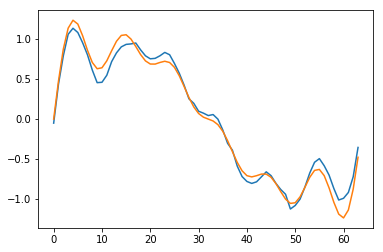

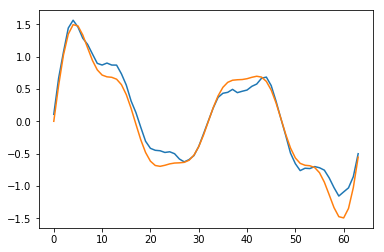

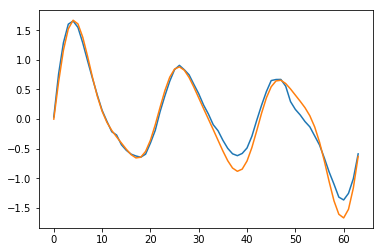

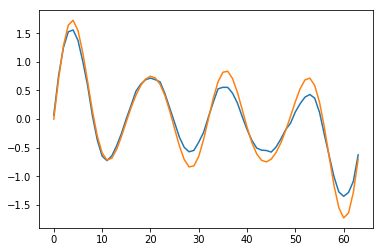

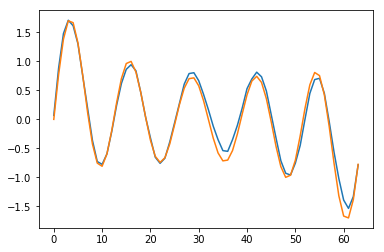

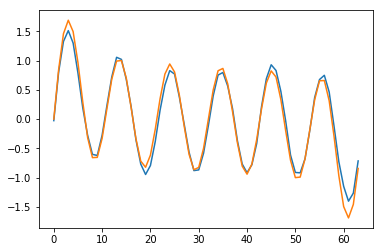

In [202]:
for i in range(D):
    plt.plot(prediction_list[i])
    plt.plot(true_list[i][64:])
    plt.show()

####  THIRD MODEL

In [24]:
nb_cells=1
learning_rate = 1e-3
hidden_size=12
input_size=6
gru=GRU_forecaster(nb_cells,hidden_size, input_size, 0.0,64,8)
loss_fn = nn.L1Loss()
D= 6
loader = get_loader(D, True)
_ , _ , predictions  = train(gru, learning_rate,loader, 60)

EPOCH 1
Train Mean loss :  -0.1267766233247022
----------------------------------------
EPOCH 2
Train Mean loss :  -0.1655869058021605
----------------------------------------
EPOCH 3
Train Mean loss :  -0.2021890832866965
----------------------------------------
EPOCH 4
Train Mean loss :  -0.24672358238594547
----------------------------------------
EPOCH 5
Train Mean loss :  -0.28359452976910515
----------------------------------------
EPOCH 6
Train Mean loss :  -0.3171757165551016
----------------------------------------
EPOCH 7
Train Mean loss :  -0.31635021414335934
----------------------------------------
EPOCH 8
Train Mean loss :  -0.3813450545256334
----------------------------------------
EPOCH 9
Train Mean loss :  -0.3872667313595497
----------------------------------------
EPOCH 10
Train Mean loss :  -0.4310635279362477
----------------------------------------
EPOCH 11
Train Mean loss :  -0.45964776651429023
----------------------------------------
EPOCH 12
Train Mean loss :

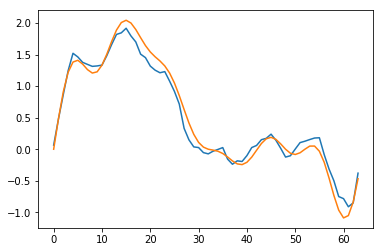

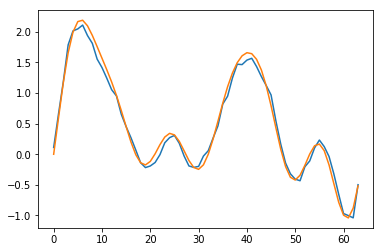

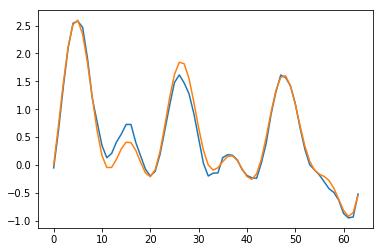

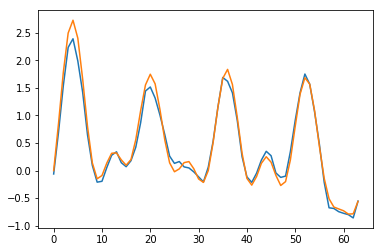

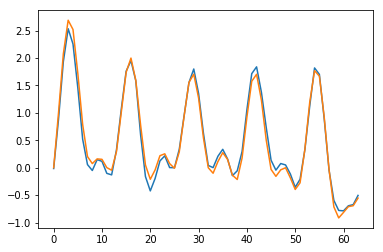

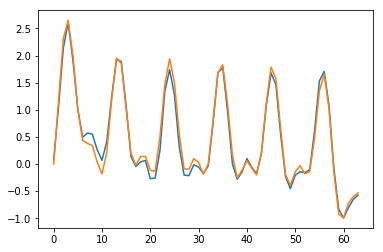

In [26]:
prediction_list = []
for i in range(D):
    l = []
    for j in range(64):
        l.append(predictions[j][0][i])
    prediction_list.append(l)
    
true_list = generate_third_type_time_series(6)

for i in range(D):
    plt.plot(prediction_list[i])
    plt.plot(true_list[i][64:])
    plt.show()

# WITH NOISE

In [66]:
nb_cells=1
learning_rate = 1e-3
hidden_size=12
input_size=6
gru=GRU_forecaster(nb_cells,hidden_size, input_size, 0.0,64,8)
loss_fn = nn.L1Loss()
D= 6
loader = get_loader(D, True)
_ , _ , predictions  = train(gru, learning_rate,loader, 60)

EPOCH 1
Train Mean loss :  -0.14803770848795048
----------------------------------------
EPOCH 2
Train Mean loss :  -0.17595788656397757
----------------------------------------
EPOCH 3
Train Mean loss :  -0.22207199317410922
----------------------------------------
EPOCH 4
Train Mean loss :  -0.2510421998636956
----------------------------------------
EPOCH 5
Train Mean loss :  -0.32447875613195265
----------------------------------------
EPOCH 6
Train Mean loss :  -0.35617260708641
----------------------------------------
EPOCH 7
Train Mean loss :  -0.4154085079172369
----------------------------------------
EPOCH 8
Train Mean loss :  -0.46365997017894717
----------------------------------------
EPOCH 9
Train Mean loss :  -0.5010627260582652
----------------------------------------
EPOCH 10
Train Mean loss :  -0.5305912502439238
----------------------------------------
EPOCH 11
Train Mean loss :  -0.5981422524262342
----------------------------------------
EPOCH 12
Train Mean loss : 

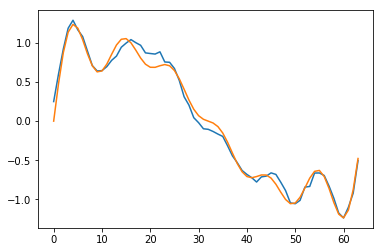

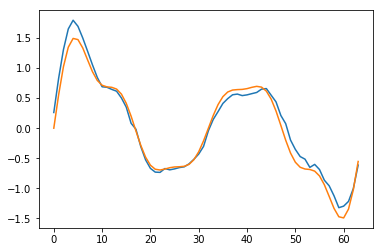

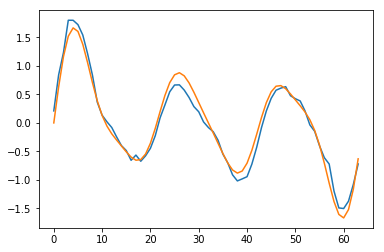

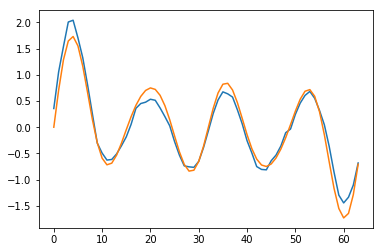

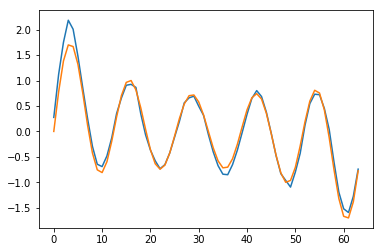

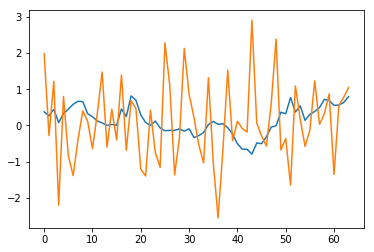

In [67]:
prediction_list = []
for i in range(D):
    l = []
    for j in range(64):
        l.append(predictions[j][0][i])
    prediction_list.append(l)
    
true_list = generate_fourth_type_time_series(6)

for i in range(D):
    plt.plot(prediction_list[i])
    plt.plot(true_list[i][64:])
    plt.show()

# BASELINE MODEL

In [11]:
def basic_model_pred(data , time_step):
    derivative = np.gradient(data)[len(data)-1]
    pred = data[len(data)-1] + (time_step)* derivative
    return(pred)

def train_basic_model(data, time_step):
    loss = 0
    prediction_list = []
    count = 0
    for time_serie in data:
        series = []
        labels = []
        predictions = []
        
        #creation of the data set
        for i in range(0,64):
            series.append(time_serie[i:i+64])
            labels.append(time_serie[i+64])

        #pred, computing loss
        
        for serie,label in zip(series,labels):
            loss += abs(basic_model_pred(serie,1)-label)
            count +=1
            predictions.append(basic_model_pred(serie,1))
        prediction_list.append(predictions)
    return(prediction_list, log(loss/count,10))



Log mean loss is -1.0416942658507555


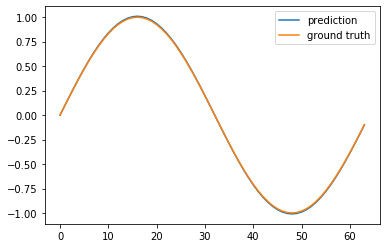

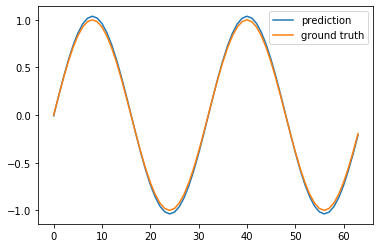

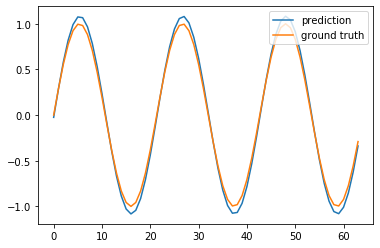

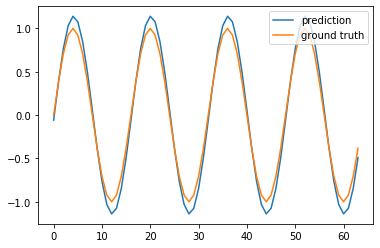

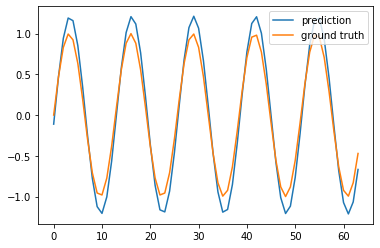

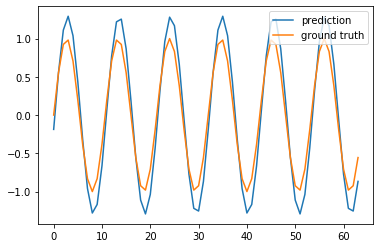

In [119]:
basic_prediction, loss = train_basic_model(generate_first_type_time_series(6),1)
print('Log mean loss is', loss)
true_list = generate_first_type_time_series(6)

for i in range(6):
    plt.plot(basic_prediction[i], label="prediction")
    plt.plot(true_list[i][64:], label="ground truth")
    plt.legend(loc='upper right')
    plt.show()

Log mean loss -0.9749637512604366


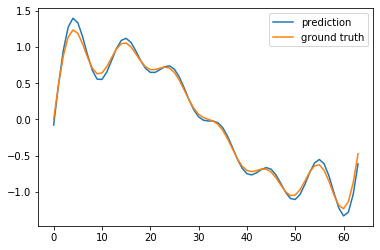

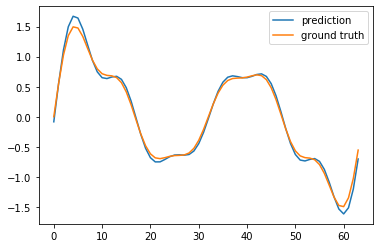

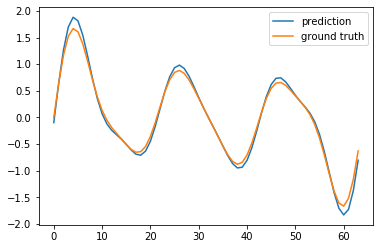

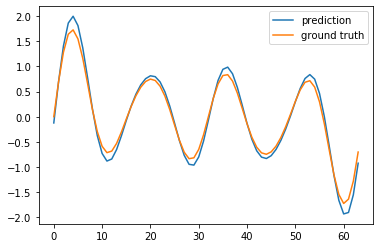

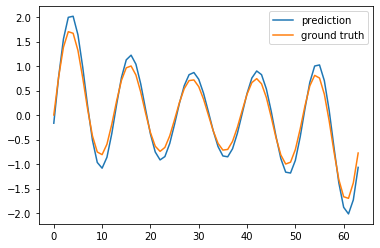

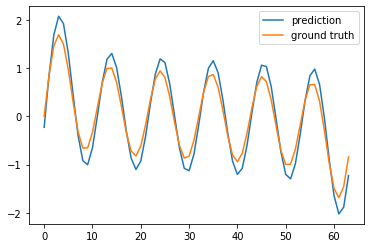

In [120]:
basic_prediction, loss = train_basic_model(generate_second_type_time_series(6),1)

true_list = generate_second_type_time_series(6)


print("Log mean loss" , loss)

for i in range(6):
    plt.plot(basic_prediction[i], label="prediction")
    plt.plot(true_list[i][64:], label="ground truth")
    plt.legend(loc='upper right')
    plt.show()

Log mean loss -0.7049321302602111


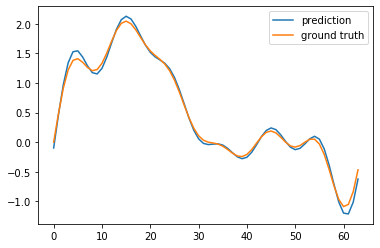

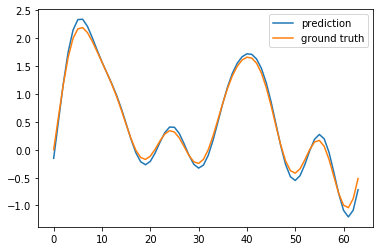

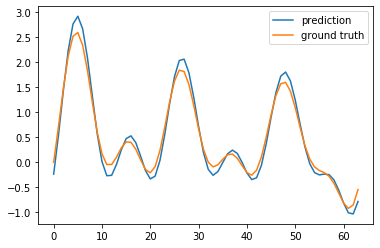

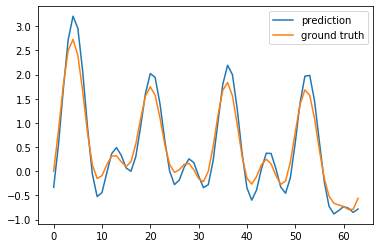

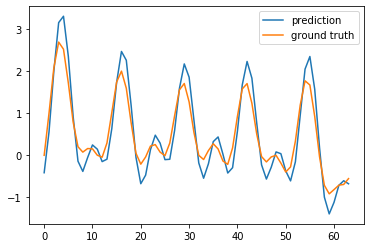

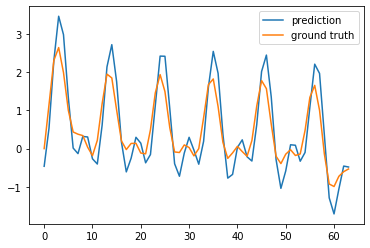

In [121]:
basic_prediction, loss = train_basic_model(generate_third_type_time_series(6),1)

true_list = generate_third_type_time_series(6)


print("Log mean loss" , loss)

for i in range(6):
    plt.plot(basic_prediction[i], label="prediction")
    plt.plot(true_list[i][64:], label="ground truth")
    plt.legend(loc='upper right')
    plt.show()

# BENCHMARKING COMPARISON

In [ ]:
loss_first_ex = []
final_accs = []
for dim in [1,6,11,16,21]:
    nb_cells=1
    learning_rate = 1e-3
    hidden_size=2*dim
    D=dim
    input_size=dim
    gru=GRU_forecaster(nb_cells,hidden_size, input_size, 0.0,64,8)
    loss_fn = nn.L1Loss()

    loader = get_loader(D, False)
    _, final_acc, _ = train(gru, learning_rate,loader)
    final_accs.append(final_acc)                            
    
    _, loss = train_basic_model(generate_first_type_time_series(dim),1)
    loss_first_ex.append(loss)
    
plt.plot([1,6,11,16,21], loss_first_ex, 'r+')

EPOCH 1
Train Mean loss :  -0.07643650551966696
----------------------------------------
EPOCH 2
Train Mean loss :  -0.11171146231230787
----------------------------------------
EPOCH 3
Train Mean loss :  -0.12650161962582168
----------------------------------------
EPOCH 4
Train Mean loss :  -0.13794540303373043
----------------------------------------
EPOCH 5
Train Mean loss :  -0.14392826510295167
----------------------------------------
EPOCH 6
Train Mean loss :  -0.14844980718899814
----------------------------------------
EPOCH 7
Train Mean loss :  -0.15189194926538846
----------------------------------------
EPOCH 8
Train Mean loss :  -0.15828338270535725
----------------------------------------
EPOCH 9
Train Mean loss :  -0.16223943682390235
----------------------------------------
EPOCH 10
Train Mean loss :  -0.16588378140721377
----------------------------------------
EPOCH 11
Train Mean loss :  -0.1695309237695581
----------------------------------------
EPOCH 12
Train Mean 

In [ ]:
with open("./result/benchmark_1_baseline_model.txt", "wb") as fp:   #Pickling
    pickle.dump(loss_first_ex, fp)
    
with open("./result/benchmark_1_attention_model.txt", "wb") as fp:   #Pickling
    pickle.dump(final_accs, fp)

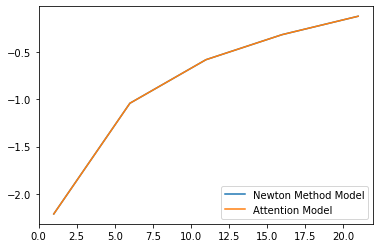

In [37]:
with open("./result/benchmark_1_baseline_model.txt", "rb") as fp:   # Unpickling
    loss_first_ex = pickle.load(fp)
with open("./refsult/benchmark_1_attention_model.txt", "rb") as fp:   # Unpickling
    final_accs = pickle.load(fp)
    
plt.plot([1,6,11,16,21] ,loss_first_ex,label= 'Newton Method Model')
plt.plot([1,6,11,16,21], final_accs,label= 'Attention Model')
plt.legend(loc='lower right')

In [38]:
loss_first_ex = []
final_accs = []
for dim in [2,6,11,16,21]:
    nb_cells=1
    learning_rate = 1e-3
    hidden_size=2*dim
    D=dim
    input_size=dim
    gru=GRU_forecaster(nb_cells,hidden_size, input_size, 0.0,64,8)
    loss_fn = nn.L1Loss()

    loader = get_loader(D, True)
    _, final_acc, _ = train(gru, learning_rate,loader)
    final_accs.append(final_acc)                            
    
    _, loss = train_basic_model(generate_second_type_time_series(dim),1)
    loss_first_ex.append(loss)
    


KeyboardInterrupt: 

In [35]:
with open("./result/benchmark_2_baseline_model.txt", "wb") as fp:   #Pickling
    pickle.dump(loss_first_ex, fp)
    
with open("./result/benchmark_2_attention_model.txt", "wb") as fp:   #Pickling
    pickle.dump(final_accs, fp)

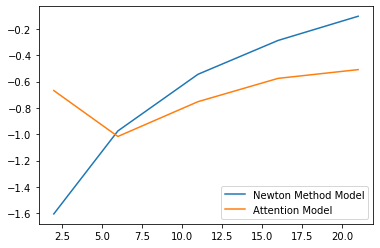

In [40]:
with open("./result/benchmark_2_baseline_model.txt", "rb") as fp:   # Unpickling
    loss_first_ex = pickle.load(fp)
with open("./result/benchmark_2_attention_model.txt", "rb") as fp:   # Unpickling
    final_accs = pickle.load(fp)
    
plt.plot([2,6,11,16,21] ,loss_first_ex,label= 'Newton Method Model')
plt.plot([2,6,11,16,21], final_accs,label= 'Attention Model')
plt.legend(loc='lower right')